In [1]:
import requests
import pandas as pd

In [2]:
data = requests.get('https://www.coingecko.com/price_charts/1/twd/90_days.json')
prices = data.json()['stats']
df = pd.DataFrame(prices)
df.columns = ['datetime','twd']
df['datetime'] = pd.to_datetime(df['datetime'], unit='ms')
df.head()

,datetime,twd
0,2019-04-12 17:03:48.875,156776.998434
1,2019-04-12 18:03:42.483,156358.833418
2,2019-04-12 19:00:41.728,156127.095858
3,2019-04-12 20:02:59.043,156057.394967
4,2019-04-12 21:02:55.180,155498.589944


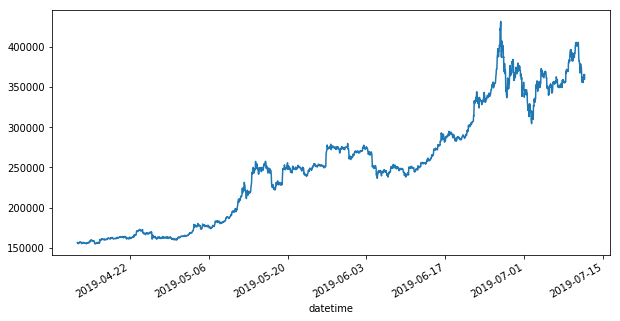

In [4]:
df.index = df['datetime']
df['twd'].plot(kind='line', figsize=[10,5])

## MA技術指標


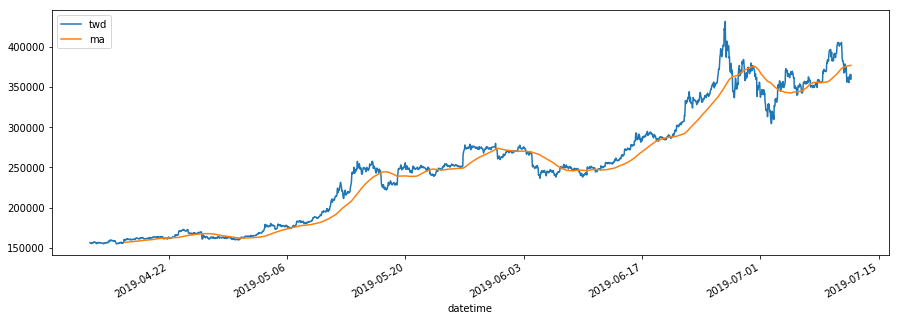

In [5]:
df['ma'] = df['twd'].rolling(window=100).mean()
df[['twd','ma']].plot(kind='line', figsize=[15,5])

### 回測

In [6]:
total = 1000000  # 投入資金
ma_num = 200     # MA
stop_earn = 1000 # 停利點

df['ma'] = df['twd'].rolling(window = ma_num).mean()
df = df[ma_num -1:]  # 去掉none值
entry_price = 0      # 進場點
max_price = 0        # 最高點
min_price = 0        # 最低點
state = 'wait_long'

for i in range(len(df)):
    # 等待做多
    if state == 'wait_long':
        if df['twd'][i] > df['ma'][i]:
            max_price = df['twd'][i]
            entry_price = df['twd'][i]
            state = 'entry_long'  # 進場做多          
    # 等待做空
    elif state == 'wait_short':
        if df['twd'][i] < df['ma'][i]:
            min_price = df['twd'][i]
            entry_price = df['twd'][i]
            state = 'entry_short' # 進場做空
    # 進場做多
    elif state == 'entry_long':
        if df['twd'][i] > max_price:
            max_price = df['twd'][i]
        if df['twd'][i] < max_price:
            total += df['twd'][i] - entry_price
            state = 'wait_short'  # 出場並等待做空
        elif df['twd'][i] - entry_price > stop_earn and stop_earn != 0:
            total += df['twd'][i] - entry_price
            state = 'wait_short'  # 出場並等待做空
    # 進場做空
    elif state == 'entry_short':
        if df['twd'][i] < min_price:
            min_price = df['twd'][i]
        if df['twd'][i] > min_price:
            total += entry_price - df['twd'][i]
            state = 'wait_long'  # 出場並等待做多
        elif entry_price - df['twd'][i] > stop_earn and stop_earn != 0:
            total += entry_price - df['twd'][i]
            state = 'wait_long'  # 出場並等待做多
 


In [7]:
print(total)

985789.3459626052


In [8]:
def get_price(url):
    res = requests.get(url)
    data_prices = res.json()['stats']
    
    df = pd.DataFrame(data_prices)
    df.columns = ['datetime', 'twd']
    df['datetime'] = pd.to_datetime(df['datetime'], unit='ms')
    
    df.index = df['datetime']
    return df

def strategy(df, total, ma_num, stop_earn):
    df['ma'] = df['twd'].rolling(window = ma_num).mean()
    df = df[ma_num -1:]  # 去掉none值
    entry_price = 0      # 進場點
    max_price = 0        # 最高點
    min_price = 0        # 最低點
    state = 'wait_long'

    for i in range(len(df)):
        # 等待做多
        if state == 'wait_long':
            if df['twd'][i] > df['ma'][i]:
                max_price = df['twd'][i]
                entry_price = df['twd'][i]
                state = 'entry_long'  # 進場做多          
        # 等待做空
        elif state == 'wait_short':
            if df['twd'][i] < df['ma'][i]:
                min_price = df['twd'][i]
                entry_price = df['twd'][i]
                state = 'entry_short' # 進場做空
        # 進場做多
        elif state == 'entry_long':
            if df['twd'][i] > max_price:
                max_price = df['twd'][i]
            if df['twd'][i] < max_price:
                total += df['twd'][i] - entry_price
                state = 'wait_short'  # 出場並等待做空
            elif df['twd'][i] - entry_price > stop_earn and stop_earn != 0:
                total += df['twd'][i] - entry_price
                state = 'wait_short'  # 出場並等待做空
        # 進場做空
        elif state == 'entry_short':
            if df['twd'][i] < min_price:
                min_price = df['twd'][i]
            if df['twd'][i] > min_price:
                total += entry_price - df['twd'][i]
                state = 'wait_long'  # 出場並等待做多
            elif entry_price - df['twd'][i] > stop_earn and stop_earn != 0:
                total += entry_price - df['twd'][i]
                state = 'wait_long'  # 出場並等待做多    
    return total


url = 'https://www.coingecko.com/price_charts/1/twd/90_days.json'
bitcoin = get_price(url)

In [9]:
total = 0

for i in range(0, 2000, 100):
    for j in range(0, 2000, 100):
        tmp_total = strategy(bitcoin, 1000000, i, j)
        if tmp_total > total:
            total = tmp_total
            best_ma = i
            best_stop_earn = j

for i in range(best_ma-100, best_ma+100, 10):
    for j in range(best_stop_earn-100, best_stop_earn+100, 10):
        tmp_total = strategy(bitcoin, 1000000, i, j)
        if tmp_total > total:
            total = tmp_total
            best_ma = i
            best_stop_earn = j
            
print("total=", total, " best_ma=", best_ma, " best_stop_earn=", best_stop_earn)

total= 1016208.3119568643  best_ma= 700  best_stop_earn= 900


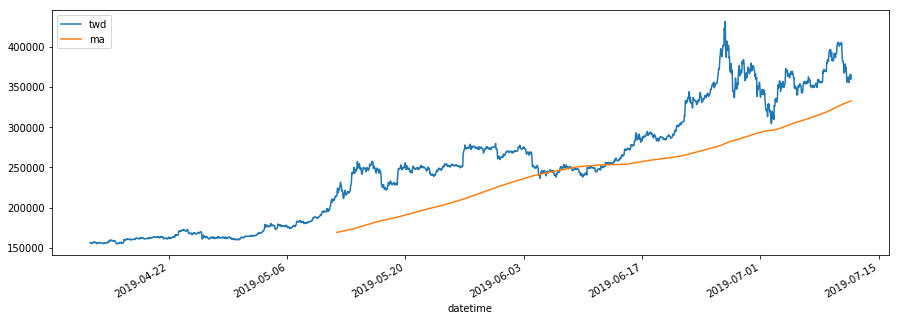

In [10]:
bitcoin['ma'] = bitcoin['twd'].rolling(window = best_ma).mean()
bitcoin[['twd','ma']].plot(kind='line', figsize=[15,5])